In [1]:
# %pip install pingouin
# %pip install statannotations 

In [4]:
"""
Statistical Analysis Pipeline for aRIN (analysis-of-results.py)

This script loads the 'results.csv' file, prepares the data for statistical
analysis, runs a Two-Way ANOVA and post-hoc tests, and generates a
publication-quality plot with significance annotations.

This follows the "Strategy Pattern" by separating data preparation,
analysis, and plotting into distinct, modular functions.
"""

import logging
from pathlib import Path
import pandas as pd
import numpy as np
from typing import Optional

import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

# --- Setup Logging ---
logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s.%(msecs)03d] [%(levelname)s] - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)


def load_and_prep_data(
    results_path: Path,
    trial: str,
    response_var: str
) -> pd.DataFrame:
    """
    Loads and prepares the results data for ANOVA.
    
    - Loads the CSV.
    - Filters for the specified trial.
    - Converts percentage DI to 0–1 proportion.
    - Creates 'Experiment' and 'Time' factors from the 'Group' column.
    - Transforms the response variable (DI) for ANOVA assumptions.
    - Filters out small groups.
    """
    logger.info(f"Loading data from {results_path}...")
    if not results_path.exists():
        logger.error(f"File not found: {results_path}")
        raise FileNotFoundError(f"File not found: {results_path}")

    df = pd.read_csv(results_path)

    # 1. Filter for the trial
    df = df[df["Trial"] == trial].copy()
    if df.empty:
        logger.error(f"No data found for trial '{trial}'. Check your CSV and config.")
        return pd.DataFrame()
    logger.info(f"Filtered for trial '{trial}', {len(df)} rows remaining.")

    # 2. Handle NaNs in the response variable
    initial_rows = len(df)
    df = df.dropna(subset=[response_var])
    if len(df) < initial_rows:
        logger.warning(
            f"Dropped {initial_rows - len(df)} rows with NaN "
            f"values in '{response_var}'"
        )

    # 2a. Convert percentage DI (e.g., 0..100) to 0–1 proportion
    logger.info(f"Converting '{response_var}' from percentage to 0–1 proportion by dividing by 100.")
    df[response_var] = df[response_var] / 100.0

    # 2b. Ensure response variable is within the expected [0, 1] range
    initial_rows = len(df)
    valid_range_mask = df[response_var].between(0, 1)
    if not valid_range_mask.all():
        dropped = (~valid_range_mask).sum()
        logger.warning(
            f"Dropped {dropped} rows with '{response_var}' outside [0, 1] "
            f"before transformation."
        )
        df = df[valid_range_mask]
    if df.empty:
        logger.error(
            f"No valid data remaining after filtering '{response_var}' to [0, 1]."
        )
        return pd.DataFrame()
    
    # 3. Feature Engineering: Split 'Group' into factors
    # This splits "TORM_1h" into "TORM" (Experiment) and "1h" (Time)
    try:
        # Use rsplit to handle group names that might have underscores
        # e.g., "MY_EXP_1h" -> ["MY_EXP", "1h"]
        split_group = df["Group"].str.rsplit("_", n=1, expand=True)
        df["Experiment"] = split_group[0]
        df["Time"] = split_group[1]
    except Exception as e:
        logger.error(f"Failed to split 'Group' column: {e}. Ensure format is 'NAME_TIME'.")
        return pd.DataFrame()

    # 4. Transform Response Variable (DI)
    # DI is now a 0–1 proportion. ANOVA requires approximately normal data.
    # Apply the standard arcsin(sqrt(x)) transform used for proportions.
    logger.info(f"Applying arcsin–sqrt transform to '{response_var}' (0–1 proportion)...")

    # Guard against any remaining invalid values before applying transform
    initial_rows = len(df)
    valid_prop_mask = df[response_var].between(0, 1)
    if not valid_prop_mask.all():
        dropped = (~valid_prop_mask).sum()
        logger.warning(
            f"Dropped {dropped} rows with '{response_var}' outside [0, 1] "
            f"before arcsin–sqrt transform."
        )
        df = df[valid_prop_mask]
    if df.empty:
        logger.error(
            f"No valid data remaining before arcsin–sqrt transform on '{response_var}'."
        )
        return pd.DataFrame()

    df[f"{response_var}_transformed"] = np.arcsin(np.sqrt(df[response_var]))
    
    # 5. Filter groups with insufficient data
    group_counts = df.groupby('Group')['Video'].count()
    valid_groups = group_counts[group_counts >= MIN_SAMPLES_PER_GROUP].index
    
    initial_rows = len(df)
    df = df[df['Group'].isin(valid_groups)]
    if len(df) < initial_rows:
        logger.warning(
            f"Dropped {initial_rows - len(df)} rows from groups "
            f"with < {MIN_SAMPLES_PER_GROUP} samples."
        )

    logger.info(
        f"Data preparation complete. {len(df)} rows ready for analysis "
        f"across {df['Group'].nunique()} groups."
    )
    return df


def _get_p_col(posthoc_df: pd.DataFrame) -> Optional[str]:
    """Return the name of the p-value column in a pingouin Tukey table.

    Different pingouin versions use different column names (e.g. 'p-adj',
    'p-tukey', 'p_tukey'). This helper makes the code robust across versions.
    """
    candidates = ["p-adj", "p-tukey", "p_tukey", "p-unc", "p"]
    for col in candidates:
        if col in posthoc_df.columns:
            return col
    return None


def run_anova_and_posthocs(
    df: pd.DataFrame,
    dv: str,
    between: list
) -> (pd.DataFrame, pd.DataFrame):
    """
    Runs a Two-Way ANOVA and Tukey post-hoc tests.
    
    dv: Dependent Variable (the transformed response)
    between: List of factors (e.g., ['Experiment', 'Time'])
    """
    logger.info("--- Running Two-Way ANOVA ---")
    
    # 1. Run ANOVA
    # We use pingouin's anova, which is robust.
    # We set detailed=True to get the full table.
    anova_result = pg.anova(
        data=df,
        dv=dv,
        between=between,
        detailed=True
    )
    # Format for printing
    anova_result_str = anova_result.to_string(index=False, float_format="%.4f")
    logger.info(f"ANOVA Results:\n{anova_result_str}")

    # 2. Run Post-Hoc Tests
    # We test for pairwise comparisons across the combined 'Group' factor
    logger.info("\n--- Running Tukey HSD Post-Hoc Test (on 'Group') ---")
    posthoc_result = pg.pairwise_tukey(
        data=df,
        dv=dv,
        between="Group"
    )

    p_col = _get_p_col(posthoc_result)
    if p_col is None:
        logger.warning(
            "Could not find a p-value column in Tukey results; "
            "available columns are: %s", list(posthoc_result.columns)
        )
        significant_posthocs = pd.DataFrame(columns=posthoc_result.columns)
    else:
        significant_posthocs = posthoc_result[posthoc_result[p_col] < 0.05]

    if not significant_posthocs.empty:
        logger.info(
            "Significant Comparisons (p < 0.05 using column '%s'):\n%s",
            p_col,
            significant_posthocs.to_string(index=False),
        )
    else:
        logger.info("No significant pairwise differences found (p > 0.05).")
        
    return anova_result, posthoc_result


def plot_results(
    df: pd.DataFrame,
    dv: str,
    response_original: str,
    posthoc_results: pd.DataFrame
) -> None:
    """
    Generates a boxplot with jitter and statistical annotations.
    """
    logger.info("Generating plot...")
    
    # --- 1. Prepare data for plotting ---
    # We plot the *original* proportion (0–1), but use the *transformed* data for stats
    x = "Group"
    y = response_original
    order = sorted(df[x].unique())

    # Get all pairs from the post-hoc results
    plot_pairs = [
        (row['A'], row['B']) for idx, row in posthoc_results.iterrows()
    ]

    if not plot_pairs:
        logger.warning("No pairs found for plotting. Skipping annotations.")
        return

    # Determine which column holds the p-values
    p_col = _get_p_col(posthoc_results)
    if p_col is None:
        logger.warning(
            "Could not find a p-value column in Tukey results; "
            "skipping statistical annotations."
        )
        p_values = None
    else:
        p_values = [row[p_col] for idx, row in posthoc_results.iterrows()]
    
    # --- 2. Create the Plot ---
    plt.figure(figsize=(12, 8))
    sns.set_theme(style="ticks", font_scale=1.1)
    
    ax = sns.boxplot(
        data=df,
        x=x,
        y=y,
        order=order,
        palette="vlag",
        showfliers=False,
        whis=1.5,
        boxprops={'alpha': 0.6}
    )
    
    # Add stripplot (jitter)
    sns.stripplot(
        data=df,
        x=x,
        y=y,
        order=order,
        palette="vlag",
        jitter=True,
        alpha=0.9,
        ax=ax
    )

    # --- 3. Add Statistical Annotations ---
    if p_values is not None:
        annotator = Annotator(
            ax,
            pairs=plot_pairs,
            data=df,
            x=x,
            y=y,
            order=order
        )
        
        # Configure and apply the annotations
        annotator.configure(
            test=None,  # We already have p-values
            text_format="star",
            loc="outside",
            verbose=False
        )
        annotator.set_pvalues(p_values)
        annotator.annotate()
    else:
        logger.info("Plotting without statistical annotations (no p-value column detected).")

    # --- 4. Finalize and Save ---
    ax.set_title(f"{response_original} by Group (Trial: {TRIAL_TO_ANALYZE})")
    ax.set_ylabel(f"{response_original} (0–1 proportion; arcsin–sqrt transformed for stats)")
    ax.set_xlabel("Group")
    ax.axhline(0.5, ls='--', color='gray', zorder=0)  # Reference line at 0.5 proportion
    plt.xticks(rotation=45, ha="right")
    sns.despine(trim=True)
    
    plt.show()

In [5]:
# --- Configuration ---
RESULTS_FILE = Path(r"examples/Interferencia/results.csv")
TRIAL_TO_ANALYZE = "TS"  # Filter for this trial (e.g., 'TS', 'Hab')
RESPONSE_VARIABLE = "DI_final"  # Column to use as the response variable
MIN_SAMPLES_PER_GROUP = 3      # Exclude groups with fewer than N samples

[2025-11-14 13:01:10.350] [INFO] - Loading data from examples\Interferencia\results.csv...
[2025-11-14 13:01:10.363] [INFO] - Filtered for trial 'TS', 48 rows remaining.
[2025-11-14 13:01:10.367] [INFO] - Converting 'DI_final' from percentage to 0–1 proportion by dividing by 100.
[2025-11-14 13:01:10.372] [INFO] - Applying arcsin–sqrt transform to 'DI_final' (0–1 proportion)...
[2025-11-14 13:01:10.377] [INFO] - Data preparation complete. 48 rows ready for analysis across 4 groups.
[2025-11-14 13:01:10.379] [INFO] - --- Running Two-Way ANOVA ---
[2025-11-14 13:01:10.424] [INFO] - ANOVA Results:
           Source     SS  DF     MS      F  p-unc    np2
       Experiment 0.0001   1 0.0001 0.0044 0.9476 0.0001
             Time 0.0214   1 0.0214 1.0040 0.3218 0.0223
Experiment * Time 0.0029   1 0.0029 0.1383 0.7117 0.0031
         Residual 0.9381  44 0.0213    NaN    NaN    NaN
[2025-11-14 13:01:10.426] [INFO] - 
--- Running Tukey HSD Post-Hoc Test (on 'Group') ---
[2025-11-14 13:01:10.533

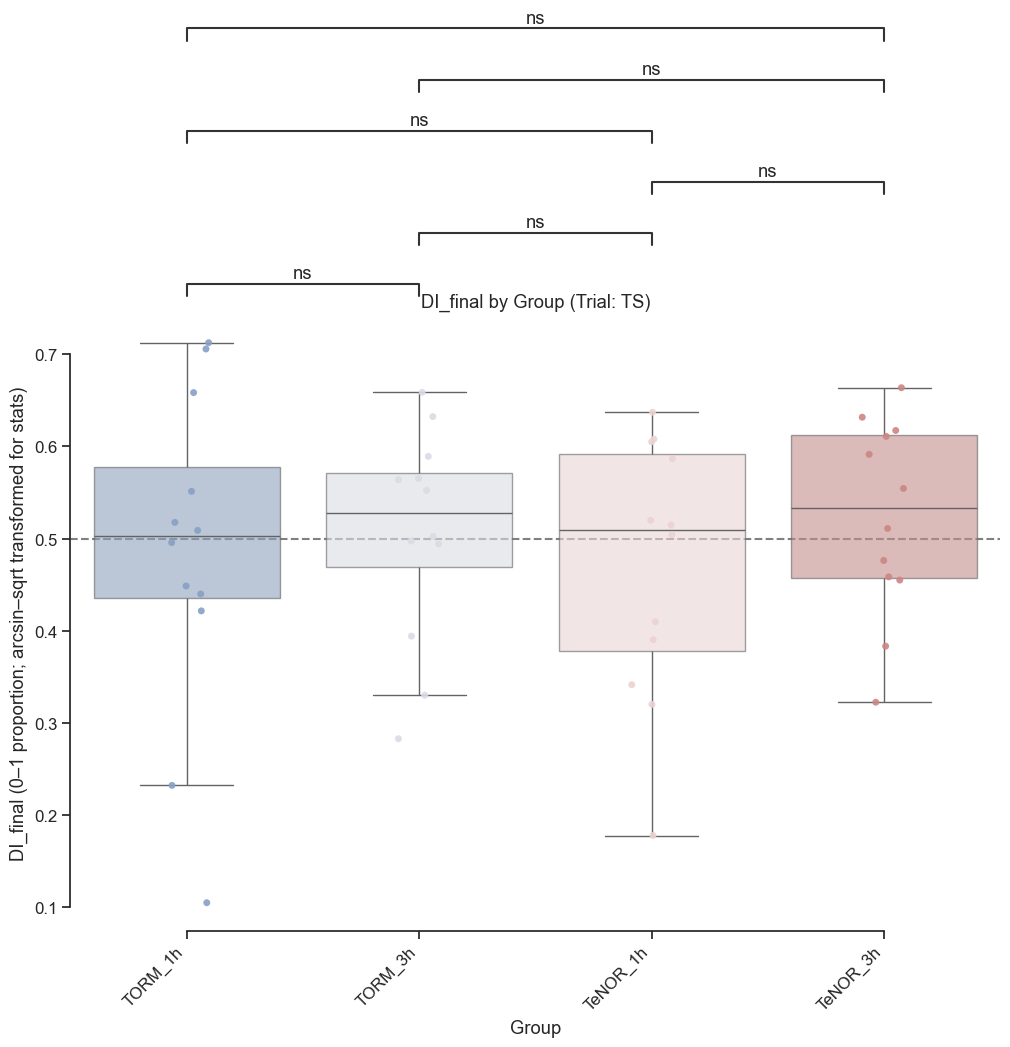

In [6]:
# 1. Prepare Data
df = load_and_prep_data(
    results_path=RESULTS_FILE,
    trial=TRIAL_TO_ANALYZE,
    response_var=RESPONSE_VARIABLE
)
    
transformed_dv = f"{RESPONSE_VARIABLE}_transformed"

# 2. Run Analysis
anova_res, posthoc_res = run_anova_and_posthocs(
    df=df,
    dv=transformed_dv,
    between=["Experiment", "Time"]
)

# 3. Plot Results
plot_results(
    df=df,
    dv=transformed_dv,
    response_original=RESPONSE_VARIABLE,
    posthoc_results=posthoc_res
    )

In [ ]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.genmod.families import links
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.sm_exceptions import PerfectSeparationError
from statsmodels.genmod.families.family import Binomial
from statsmodels.formula.api import glm
from statsmodels.stats.multitest import multipletests
from statsmodels.regression.linear_model import OLS
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.discrete.discrete_model import Logit
from statsmodels.stats.contrast import ContrastResults
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.weightstats import DescrStatsW
from statsmodels.miscmodels import TLinearModel
from statsmodels.genmod.generalized_linear_model import GLMResults
from statsmodels.genmod.families import Beta
from statsmodels.formula.api import glm
from patsy import dmatrix, dmatrices

# ==========================================================
# 1. Load data
# ==========================================================

df = pd.read_csv("results.csv")

# Identify columns explicitly (adjust if different)
trial_col = "Trial"
group_col = "Group"
di_col = "DI_final"

# Filter to TS only
df = df[df[trial_col] == "TS"].copy()

# ==========================================================
# 2. Scale DI to (0,1)
# ==========================================================

if df[di_col].max() > 1.1:
    df["DI_scaled"] = df[di_col] / 100.0
else:
    df["DI_scaled"] = df[di_col]

# Avoid exact 0 or 1 (beta distribution requires (0,1))
epsilon = 1e-4
df["DI_scaled"] = df["DI_scaled"].clip(epsilon, 1 - epsilon)

# ==========================================================
# 3. Fit Beta regression
# ==========================================================

formula = "DI_scaled ~ C(Group)"

model = sm.families.Beta(link=sm.families.links.logit())

beta_model = sm.GLM.from_formula(
    formula,
    data=df,
    family=model
)

beta_res = beta_model.fit()
print("\n=== β-regression model summary ===")
print(beta_res.summary())

# ==========================================================
# 4. Predicted marginal means per group
# ==========================================================

groups = df[group_col].unique()
pred_means = []

for g in groups:
    new_df = pd.DataFrame({group_col: [g]})
    pred = beta_res.predict(new_df)[0]
    pred_means.append((g, pred))

marginal_means = pd.DataFrame(pred_means, columns=["Group", "Predicted_DI"])
marginal_means.to_csv("marginal_means_beta.csv", index=False)
print("\nSaved marginal_means_beta.csv")

# ==========================================================
# 5. Pairwise contrasts
# ==========================================================

contrast_rows = []
combinations = list(itertools.combinations(groups, 2))

for g1, g2 in combinations:
    # Construct contrast vector manually based on parameter names
    params = beta_res.params

    # Base level is alphabetical; get names from model
    param_names = beta_res.params.index.tolist()

    # Build contrast vector
    L = np.zeros(len(params))
    # Intercept cancels out by default

    # group indicators follow pattern C(Group)[T.X]
    name1 = f"C(Group)[T.{g1}]"
    name2 = f"C(Group)[T.{g2}]"

    if name1 in param_names:
        L[param_names.index(name1)] = 1
    if name2 in param_names:
        L[param_names.index(name2)] = -1

    # Compute contrast
    est = float(L @ params)
    se = float(np.sqrt(L @ beta_res.cov_params() @ L.T))
    z = est / se
    p = 2 * (1 - sm.stats.norm.cdf(abs(z)))

    contrast_rows.append([g1, g2, est, se, z, p])

contrasts = pd.DataFrame(
    contrast_rows,
    columns=["Group1", "Group2", "Estimate(logit)", "SE", "Z", "p"]
)

contrasts.to_csv("beta_pairwise_contrasts.csv", index=False)
print("Saved beta_pairwise_contrasts.csv")

# ==========================================================
# 6. Plot raw distributions
# ==========================================================

plt.figure(figsize=(10,6))
for g in groups:
    sub = df[df[group_col] == g]["DI_scaled"]
    plt.hist(sub, bins=8, alpha=0.6, label=g)

plt.xlabel("DI_scaled (0-1)")
plt.ylabel("Count")
plt.title("Histogram of DI_scaled by group (TS)")
plt.legend()
plt.tight_layout()
plt.savefig("histograms_beta.png", dpi=300)
print("Saved histograms_beta.png")

# ==========================================================
# 7. Plot predicted means with raw means
# ==========================================================

plt.figure(figsize=(10,6))

# observed means & SE
obs = df.groupby(group_col)["DI_scaled"].agg(["mean", "sem"]).reset_index()

# merge
plot_df = obs.merge(marginal_means, on="Group")

x = np.arange(len(plot_df))

# observed means
plt.errorbar(
    x - 0.1, plot_df["mean"], yerr=plot_df["sem"],
    fmt="o", label="Observed", capsize=4
)

# predicted means
plt.scatter(x + 0.1, plot_df["Predicted_DI"], label="Beta model", color="orange")

plt.xticks(x, plot_df["Group"])
plt.ylabel("DI (0-1)")
plt.title("Observed vs Predicted DI (Beta regression)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("beta_model_means.png", dpi=300)
print("Saved beta_model_means.png")

print("\nAll done.")
